# MONARCHS Lid Physics Test Harness

This notebook tests if the lid can ever shrink from the bottom 

The reason to test the lid code is because the 1D ERA5 runs produce lid depths that **only grow** or **reset to zero** after combine_lid_firn 

i.e. the lid never shrinks

In [33]:
# Basal lid test harness for MONARCHS
import numpy as np
from monarchs.physics import lid_functions

def make_basal_test_cell(lid_depth=0.5, lake_temp=274.5):
    """Construct a minimal MONARCHS cell for basal lid testing."""
    return {
        # Bookkeeping
        "day": 0,
        "t_step": 0,
        "melt": 0.0,
        "exposed_water": False,

        # Lid state
        "lid": True,
        "v_lid": False,
        "has_had_lid": True,
        "lid_depth": lid_depth,
        "v_lid_depth": 0.0,
        "lid_melt_count": 0,
        "lid_temperature": np.ones(20) * 273.15,
        "rho_lid": np.ones(20) * 917.0,

        # Constants
        "rho_ice": 917.0,
        "rho_water": 1000.0,
        "L_ice": 3.34e5,
        "k_air": 0.024,
        "cp_air": 1005.0,
        "k_water": 0.6,

        # Lake
        "lake": True,
        "lake_depth": 1.0,
        "lake_temperature": np.ones(20) * lake_temp,

        # Firn 
        "Sfrac": np.ones(500),
        "Lfrac": np.zeros(500),
        "firn_depth": np.linspace(0, 35.0, 500),
        "lid_sfc_melt": 0,

        # Grid
        "vert_grid": 500,
        "vert_grid_firn": 500,
        "vert_grid_lid": 20,
        "vert_grid_lake": 20,
    }

=== Warm lake basal test ===


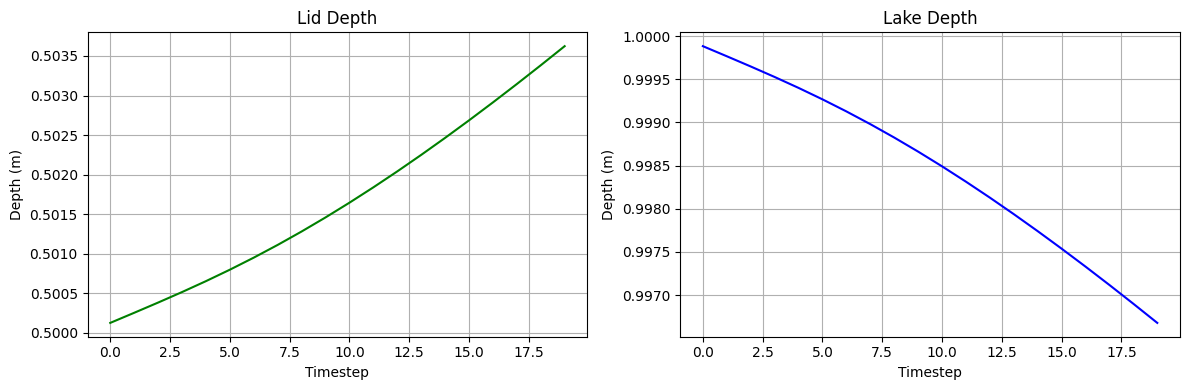

In [34]:
import matplotlib.pyplot as plt

def run_basal_test(cell, steps=6, dt=3600.0):
    lid_depths = []
    lake_depths = []

    for step in range(steps):
        lid_functions.lid_development(
            cell, dt,
            LW_in=0.0,
            SW_in=0.0,
            T_air=273.15,
            p_air=1.0e5,
            T_dp=273.15,
            wind=0.0,
        )

        lid_depths.append(cell["lid_depth"])
        lake_depths.append(cell["lake_depth"])

        #print(
        #    f"Step {step}: "
        #    f"lid_depth={cell['lid_depth']:.6f}, "
        #    f"lake_depth={cell['lake_depth']:.6f}"
        #)

    # --- Side-by-side plots ---
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

    axs[0].plot(range(steps), lid_depths, color="green")
    axs[0].set_title("Lid Depth")
    axs[0].set_xlabel("Timestep")
    axs[0].set_ylabel("Depth (m)")
    axs[0].grid(True)

    axs[1].plot(range(steps), lake_depths, color="blue")
    axs[1].set_title("Lake Depth")
    axs[1].set_xlabel("Timestep")
    axs[1].set_ylabel("Depth (m)")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


# === Warm lake ===
print("=== Warm lake basal test ===")
cell_warm = make_basal_test_cell(lid_depth=0.5, lake_temp=274.5)
run_basal_test(cell_warm, steps=20)


## Warm lake test

We initialise the lake temp with 274.15K (**1oC**)

Expectation (Buzzard, 2018):  
- Permanent lid should thin and and lake should grow  

Observed in MONARCHS:  
- Permanent lid grows  


## Discussion

This look is suspect:

```python
kdTdz = (
        (-cell["lake_temperature"][2] + cell["lid_temperature"][-2])
        * abs(cell["k_water"])
        / (
            cell["lake_depth"] / cell["vert_grid_lake"]
            + cell["lid_depth"] / cell["vert_grid_lid"]
        )
    )
    new_boundary_change = -kdTdz / (cell["L_ice"] * cell["rho_ice"]) * dt
```

- the minus sign for the temperature gradient
- the use of top third level of lake and bottom third level of lid is used for the temperature gradient   
- new_boundary_change is always positive 
- even if it were possible to have negative new_boundary_change - there is no logic to say what happens if new_boundary_change < 0   